In [1]:
import os
# change to the upper level folder to detect dj_local_conf.json
if os.path.basename(os.getcwd())=='notebooks': os.chdir('..')
assert os.path.basename(os.getcwd())=='adamacs', ("Please move to the main directory")
from adamacs.pipeline import subject, session, equipment, surgery, event, trial, imaging, behavior, scan, model
from adamacs.ingest import session as isess
from adamacs.helpers import stack_helpers as sh
from adamacs.ingest import behavior as ibe
import datajoint as dj
from rspace_client.eln import eln
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
dj.__version__

[2023-12-11 15:45:03,529][INFO]: Connecting tobiasr@172.26.128.53:3306
[2023-12-11 15:45:03,576][INFO]: Connected tobiasr@172.26.128.53:3306


'0.14.1'

### some functions used here (will be hidden later)

In [2]:
import bisect
import numpy as np
from skimage.transform import resize
from tqdm import tqdm
import concurrent.futures
import cv2

def get_closest_timestamps(series, target_timestamp):
    # List to store the indices
    indices = []

    # For each timestamp in series1, find the closest timestamp in series2 and get its index
    for t1 in series:
        closest_index = closest_timestamp(target_timestamp, t1)
        indices.append(closest_index)
    return indices

# Function to find closest timestamp
def closest_timestamp(series, target_timestamp):
    index = bisect.bisect_left(series, target_timestamp)
    if index == 0:
        return 0
    if index == len(series):
        return len(series)-1
    before = series[index - 1]
    after = series[index]
    if after - target_timestamp < target_timestamp - before:
       return index
    else:
       return index-1


def resize_movie(movie, new_height, new_width):
    # Get the number of frames and color channels
    num_frames, _, _, num_channels = movie.shape
    
    # Initialize an empty array for the scaled movie
    scaled_movie = np.empty((num_frames, new_height, new_width, num_channels), dtype=np.uint8)
    
    # Iterate through each frame
    for i in tqdm(range(num_frames), desc="Resizing frames"):
        # Resize the frame and store it in the new array
        scaled_movie[i] =  cv2.resize(movie[i], (new_width, new_height), interpolation = cv2.INTER_AREA)
    
    # Return the scaled movie
    return scaled_movie


def resize_frame(frame, new_height, new_width):
    return cv2.resize(frame, (new_width, new_height), interpolation = cv2.INTER_AREA)

def resize_movie_mt(movie, new_height, new_width):
    num_frames, _, _, num_channels = movie.shape
    scaled_movie = np.empty((num_frames, new_height, new_width, num_channels), dtype=np.uint8)

    with concurrent.futures.ThreadPoolExecutor() as executor:
        for i, resized_frame in tqdm(enumerate(executor.map(resize_frame, movie, [new_height]*num_frames, [new_width]*num_frames)), total=num_frames, desc="Resizing frames"):
            scaled_movie[i] = resized_frame

    return scaled_movie


import numpy as np
from skimage.transform import resize
import concurrent.futures


# Figure Style settings for notebook.

import matplotlib as mpl

plot_params = {
    'axes.facecolor': 'white',
    'figure.facecolor': 'white',
    'font.family': 'sans-serif',
    # 'font.sans-serif': 'Helvetica Neue',
    'font.size': 16,
    'lines.color': 'black',
    'xtick.direction': 'out',
    'ytick.direction': 'out',
    'xtick.color': 'black',
    'ytick.color': 'black',
    'axes.spines.left': True,
    'axes.spines.bottom': True,
    'axes.spines.top': True,
    'axes.spines.right': True,
    'axes.edgecolor': 'black',  
    # 'legend.frameon': False,
    'figure.subplot.wspace': .5,
    'figure.subplot.hspace': .5,
    # 'figure.figsize': (18, 13),
    'ytick.major.left': True,
    'xtick.major.bottom': True
}

map_params = {
    'axes.facecolor': 'white',
    'figure.facecolor': 'white',
    'font.family': 'sans-serif',
    # 'font.sans-serif': 'Helvetica Neue',
    'font.size': 12,
    'lines.color': 'black',
    'xtick.direction': 'out',
    'ytick.direction': 'out',
    'xtick.color': 'black',
    'ytick.color': 'black',
    'axes.spines.left': False,
    'axes.spines.bottom': False,
    'axes.spines.top': False,
    'axes.spines.right': False,
    'axes.edgecolor': 'black',  
    # 'legend.frameon': False,
    'figure.subplot.wspace': .5,
    'figure.subplot.hspace': .5,
    # 'figure.figsize': (18, 13),
    'ytick.major.left': False,
    'xtick.major.bottom': False
}


img_params = {
    'axes.facecolor': 'black',
    'figure.facecolor': 'black',
    'axes.spines.left': False,
    'axes.spines.bottom': False,
    'axes.spines.top': False,
    'axes.spines.right': False,
    'legend.frameon': False,
    'figure.subplot.wspace': .01,
    'figure.subplot.hspace': .01,
    'figure.figsize': (18, 13),
    'ytick.major.left': False,
    'xtick.major.bottom': False
}


# Recordings and example analysis for BonnBrain - JISOOJ

In [3]:
# Jisoo - example scans

# mini2p
# sessi = sess9FJBPNSP


# bench2p
# sessi = sess9FH37WBZ


# Bench2p figures and examples

In [11]:
# first define a key to be used across multiple tables

scansi = "scan9FKSN4XD"
scan_key = (scan.Scan & f'scan_id = "{scansi}"').fetch('KEY')[0]
curation_key = (imaging.Curation & scan_key & 'curation_id=1').fetch1('KEY')
sessi = (scan.Scan & f'scan_id = "{scansi}"').fetch('session_id')[0]
aux_setup_typestr = (scan.ScanInfo() & scan_key).fetch("userfunction_info")[0] # check setup type (not needed)
print(aux_setup_typestr)
print((scan.ScanPath & scan_key).fetch("path")[0])

mini2p1_openfield
/datajoint-data/data/tobiasr/JJ_ROS-1604_2023-10-27_scan9FKSN4XD_sess9FKSN4XD


In [12]:
session.Session & 'subject = "ROS-1604"'

session_id,subject PyRat import uses this for earmark value,session_datetime
sess9FKAQIFC,ROS-1604,2023-09-27 00:00:00
sess9FKAQOMW,ROS-1604,2023-09-27 00:00:00
sess9FKAQWOX,ROS-1604,2023-09-27 00:00:00
sess9FKAR6L5,ROS-1604,2023-09-27 00:00:00
sess9FKARAPO,ROS-1604,2023-09-27 00:00:00
sess9FKBCD2M,ROS-1604,2023-09-28 00:00:00
sess9FKBCLRZ,ROS-1604,2023-09-28 00:00:00
sess9FKBCUSK,ROS-1604,2023-09-28 00:00:00
sess9FKBCXZ4,ROS-1604,2023-09-28 00:00:00
sess9FKNBQCS,ROS-1604,2023-10-18 00:00:00


### Get and show overview images from suite2p registration

In [13]:
ref_image = (imaging.MotionCorrection.Summary & curation_key & 'field_idx=0').fetch1('ref_image')
average_image = (imaging.MotionCorrection.Summary & curation_key & 'field_idx=0').fetch1('average_image')
correlation_image = (imaging.MotionCorrection.Summary & curation_key & 'field_idx=0').fetch1('correlation_image')
max_proj_image = (imaging.MotionCorrection.Summary & curation_key & 'field_idx=0').fetch1('max_proj_image')

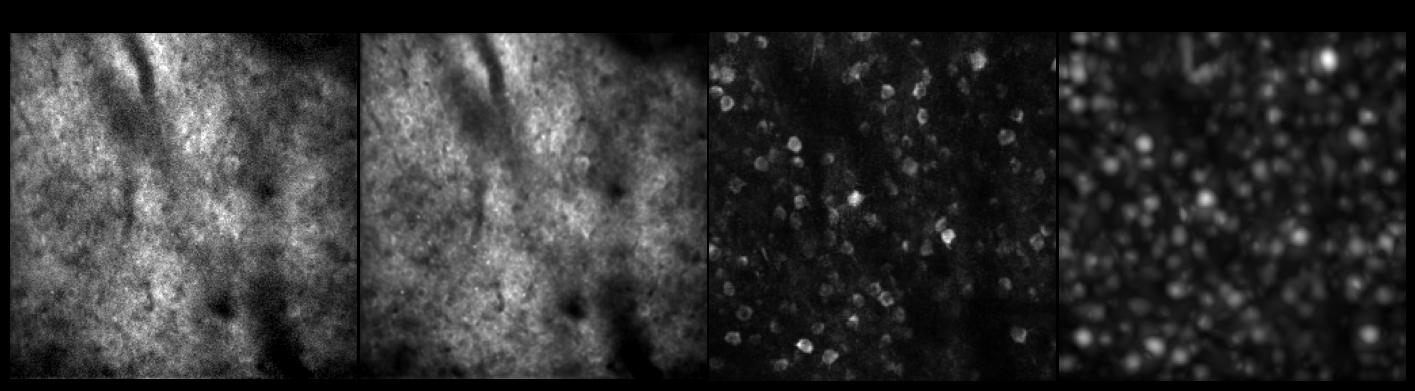

In [14]:
# get some scaling values from pixel distribution
scalemin = 1
scalemax = 100

cmin = np.percentile(average_image,scalemin)  
cmax = np.percentile(average_image,scalemax)

# load image styles for display
mpl.rcParams.update(mpl.rcParamsDefault)
mpl.rcParams.update(img_params)

# Make figure with all templates
plt.subplot(1, 4, 1)
plt.imshow(ref_image, cmap='gray', vmin = cmin, vmax = cmax)
plt.title("Reference Image for Registration");

plt.subplot(1, 4, 2)
plt.imshow(average_image, cmap='gray', vmin = cmin, vmax = cmax)
plt.title("Registered Image, Mean Projection");

plt.subplot(1, 4, 3)
plt.imshow(max_proj_image, cmap='gray')
plt.title("Registered Image, Max Projection")

plt.subplot(1, 4, 4)
plt.imshow(correlation_image, cmap='gray')
plt.title("Registered Image, Correlation Map")
plt.show(block=False)
# plt.savefig

In [ ]:
# just mean image
scalemin = 1
scalemax = 100

cmin = np.percentile(average_image,scalemin)  
cmax = np.percentile(average_image,scalemax)


# plt.subplot(1, 4, 1)
plt.imshow(max_proj_image, cmap='gray', vmin = cmin, vmax = cmax)
plt.show()


### Plot treadmill data

In [ ]:
# extract scan treadmill data from database using the scan_key from above
treadmill = (behavior.TreadmillRecording.Channel() & scan_key).fetch("data")[0]
auxtime = (behavior.TreadmillRecording.Channel() & scan_key).fetch("time")[0]

In [ ]:
# smoothing window size (ms)
window = 5000

# convert voltage to degree
treadmillnorm = (treadmill-np.min(treadmill)) / np.max(treadmill) * 360

# compute running speed (see function above)
angular_velocity_smoothed, unwrapped_angle_smoothed = ibe.compute_angular_velocity(auxtime, treadmillnorm, window)

# get some values to scale running speed plot 
scalemin = 0
scalemax = 100
offset = 10
ymin = np.percentile(angular_velocity_smoothed,scalemin)  - offset
ymax = np.percentile(angular_velocity_smoothed,scalemax)  + offset

# load plot styles for display
mpl.rcParams.update(mpl.rcParamsDefault)
mpl.rcParams.update(plot_params)


fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(15, 10))
# plt.rcParams['agg.path.chunksize'] = 10000  # Add this line if it does not rende

# Plotting the time series
axes[0].plot(auxtime, treadmillnorm)
axes[0].set_ylim([-10, 370])
axes[0].set_ylabel("Wheel position \n[degree]")
axes[0].set_xlabel("Time [s]")

axes[1].plot(auxtime[:-window+1],unwrapped_angle_smoothed )
# axes[1].set_ylim([-10000, 10000])
axes[1].set_ylabel("Unwrapped wheel position \n[cumulative degree]")
axes[1].set_xlabel("Time [s]")

axes[2].plot(auxtime[:-window],angular_velocity_smoothed)
axes[2].set_ylim([ymin, ymax])
axes[2].set_ylabel("Running speed \n[degree / s]")
axes[2].set_xlabel("Time [s]")

fig.suptitle(scan_key["scan_id"], fontsize=16)

plt.show() 

### Get the fluorescence traces of this recording

In [ ]:
# get mask positions of masks that are classified as cells and that are larger than a certain pixel size
mask_xpix, mask_ypix = (
    imaging.Segmentation.Mask * imaging.MaskClassification.MaskType
    & scan_key
    & "mask_npix > 1"
).fetch("mask_xpix", "mask_ypix")

Using this query, we've fetched the coordinates of segmented masks. We can overlay these
masks onto our average image.

In [ ]:
mask_image = np.zeros(np.shape(average_image), dtype=bool)
for xpix, ypix in zip(mask_xpix, mask_ypix):
    mask_image[ypix, xpix] = True

In [ ]:
# load image styles for display
mpl.rcParams.update(mpl.rcParamsDefault)
mpl.rcParams.update(img_params)

plt.imshow(average_image, cmap='gray', vmin = cmin, vmax = cmax)
plt.contour(mask_image, colors="red", linewidths=0.5)
plt.show()

One more example using queries - plot fluorescence and deconvolved activity
traces:

Here we fetch the primary key attributes of the entry with `curation_id=0` for the
current session in the `imaging.Curation` table. 

Then, we fetch all cells that fit the
restriction criteria from `imaging.Segmentation.Mask` and
`imaging.MaskClassification.MaskType` as a `projection`. 

We then use this projection as
a restriction to fetch and plot fluorescence and deconvolved activity traces from the
`imaging.Fluorescence.Trace` and `imaging.Activity.Trace` tables, respectively.

In [ ]:
curation_key = (imaging.Curation & scan_key & "curation_id=1").fetch1("KEY")
query_cells = (
    imaging.Segmentation.Mask * imaging.MaskClassification.MaskType
    & curation_key
    & "mask_center_z=0"
    & "mask_npix > 1"
).proj()

# query_cells

In [ ]:
neuropilcorr = True

fluorescence_traces = (imaging.Fluorescence.Trace & query_cells).fetch(
    "fluorescence", order_by="mask"
)

neuropil_traces = (imaging.Fluorescence.Trace & query_cells).fetch(
    "neuropil_fluorescence", order_by="mask"
)

if neuropilcorr:
    print("DOING VANILLA NEUROPIL CORRECTION NOW!")
    fluorescence_traces = fluorescence_traces - 0.7 * neuropil_traces

activity_traces = (imaging.Activity.Trace & query_cells).fetch(
    "activity_trace", order_by="mask"
)

sampling_rate = (scan.ScanInfo & curation_key).fetch1("fps")

# timebase_2p = np.r_[: fluorescence_traces[0].size] * 1 / sampling_rate

timebase_2p = np.linspace(0, fluorescence_traces[0].size / sampling_rate, fluorescence_traces[0].shape[0])


In [ ]:
from rastermap import Rastermap
from scipy import stats 
from scipy.stats import zscore
from scipy.ndimage import gaussian_filter1d

# stack fluorescence for rastermap
fluos = np.vstack(fluorescence_traces)

nan_mask = np.isnan(fluos).any(axis=1)
S = fluos[~nan_mask]
S = zscore(S, axis=1)

rmmodel = Rastermap(n_clusters=None, # None turns off clustering and sorts single neurons 
                  n_PCs=100, # use fewer PCs than neurons
                  locality=0.15, # some locality in sorting (this is a value from 0-1)
                  time_lag_window=15, # use future timepoints to compute correlation
                  grid_upsample=0, # 0 turns off upsampling since we're using single neurons
                ).fit(S)


y = rmmodel.embedding # neurons x 1
isort = rmmodel.isort

# sort by embedding and smooth over neurons (uncomment)

# Sfilt = gaussian_filter1d(S[isort], np.minimum(1,np.maximum(1,int(S.shape[0]*0.001))),axis=0)
Sfilt = S[isort]

In [ ]:
# Plot sorted data
# load plot styles for display

mpl.rcParams.update(mpl.rcParamsDefault)
mpl.rcParams.update(plot_params)

plt.figure(figsize=(5,3))
plt.imshow(Sfilt, vmin = -0.1, vmax=1, extent= [timebase_2p[0], timebase_2p[-1], 0, Sfilt.shape[0]], aspect='auto', cmap='gray_r')
plt.xlabel('time [s]')
plt.ylabel('sorted boutons')
plt.show()

Different visualization


In [ ]:
import seaborn as sns
figure = plt.figure(figsize=(15,15))
ax = figure.add_subplot(111)

offset_scaler = 20 # We want to plot every cell with a little offset to the last one
for no,trace in enumerate(Sfilt):
    if no == 80: break # not more than 80

    # get the neuropil corrected values for that trace:
    # trace = Sfilt
    ax.plot(timebase_2p,trace + (no*offset_scaler),lw=1,c='k',alpha=.8)

ax.set_xlim(0,timebase_2p[-1])

ax.get_yaxis().set_ticks([])
ax.set_title('Sorted z-scored traces')    

ax.set_ylabel('Cells')
ax.set_xlabel('Time [s]')
sns.despine(left=True)

plt.show()

#### Synchronization!

In [ ]:
# and 2p timestamps (which will always be in the recording gate).
twoptimestamps = (event.Event()  &  "event_type='bench2p_frames'" &  scan_key ).fetch('event_start_time')
aligned_wheel_indices = get_closest_timestamps(twoptimestamps,auxtime[:-window]) #smoothing windwo from above

# use this to index into the wheelspeed
angular_velocity_smoothed_2pref = angular_velocity_smoothed[aligned_wheel_indices]

# both arrays have same shape now - now 2pdata and wheel speed can be plotted together on the 2ptimestamps
print(np.shape(twoptimestamps))
print(np.shape(angular_velocity_smoothed_2pref))


In [ ]:
kp_colors = np.array([[0.55,0.55,0.55]])


# timepoints to visualize
tstart = 0
tend =  timebase_2p[-1] - 150

xmin = int(np.floor(tstart * sampling_rate))
xmax = int(np.floor(tend * sampling_rate))

# make figure with grid for easy plotting
fig = plt.figure(figsize=(14,5), dpi=200)
grid = plt.GridSpec(9, 20, figure=fig, wspace = 0.05, hspace = 0.3)

# plot running speed
ax = plt.subplot(grid[:2, :-1])
ax.plot(angular_velocity_smoothed_2pref,  color=kp_colors[0])
ax.set_xlim([0, xmax-xmin])

ax.tick_params(left=False, right=False, bottom=False, top=False,
               labelleft=False, labelbottom=False)
for spine in ax.spines.values():
    spine.set_visible(False)
ax.set_ylabel("treadmill\nspeed")
ax.yaxis.set_label_position("left")
# ax.axis("off")


# ax.set_title("running speed", color=kp_colors[0])
# ax.set_xlabel("running speed")

# plot superneuron activity
ax = plt.subplot(grid[2:, :-1])
ax.imshow(Sfilt[:, xmin:xmax], cmap="gray_r", vmin=-0.1, vmax=0.7,  extent= [timebase_2p[xmin], timebase_2p[xmax], 0, Sfilt.shape[0]], aspect="auto")
ax.set_xlabel("time [s]")
ax.set_ylabel("sorted boutons")

plt.show()
plt.savefig
# ax = plt.subplot(grid[1:, -1])
# ax.imshow(np.arange(0, len(sn))[:,np.newaxis], cmap="gist_ncar", aspect="auto")
# ax.axis("off")

# Mini2p figures and examples

In [15]:
# first define a key to be used across multiple tables

scansi = "scan9FKSN4XD"
scan_key = (scan.Scan & f'scan_id = "{scansi}"').fetch('KEY')[0]
curation_key = (imaging.Curation & scan_key & 'curation_id=1').fetch1('KEY')
sessi = (scan.Scan & f'scan_id = "{scansi}"').fetch('session_id')[0]
aux_setup_typestr = (scan.ScanInfo() & scan_key).fetch("userfunction_info")[0] # check setup type (not needed)
print(aux_setup_typestr)
print((scan.ScanPath & scan_key).fetch("path")[0])

mini2p1_openfield
/datajoint-data/data/tobiasr/JJ_ROS-1604_2023-10-27_scan9FKSN4XD_sess9FKSN4XD


### Get and show overview images from suite2p registration

In [16]:
ref_image = (imaging.MotionCorrection.Summary & curation_key & 'field_idx=0').fetch1('ref_image')
average_image = (imaging.MotionCorrection.Summary & curation_key & 'field_idx=0').fetch1('average_image')
correlation_image = (imaging.MotionCorrection.Summary & curation_key & 'field_idx=0').fetch1('correlation_image')
max_proj_image = (imaging.MotionCorrection.Summary & curation_key & 'field_idx=0').fetch1('max_proj_image')

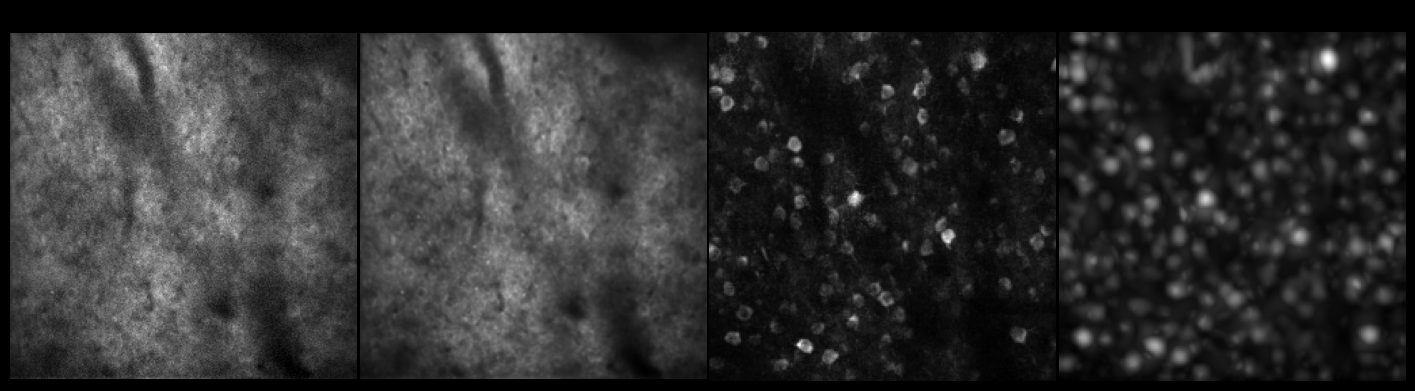

In [17]:
# get some scaling values from pixel distribution
scalemin = 0
scalemax = 100
offset = 150


cmin = np.percentile(average_image,scalemin)  
cmax = np.percentile(average_image,scalemax) + offset

# load image styles for display
mpl.rcParams.update(mpl.rcParamsDefault)
mpl.rcParams.update(img_params)

# Make figure with all templates
plt.subplot(1, 4, 1)
plt.imshow(ref_image, cmap='gray', vmin = cmin, vmax = cmax)
plt.title("Reference Image for Registration");

plt.subplot(1, 4, 2)
plt.imshow(average_image, cmap='gray', vmin = cmin, vmax = cmax)
plt.title("Registered Image, Mean Projection");

plt.subplot(1, 4, 3)
plt.imshow(max_proj_image, cmap='gray')
plt.title("Registered Image, Max Projection")

plt.subplot(1, 4, 4)
plt.imshow(correlation_image, cmap='gray')
plt.title("Registered Image, Correlation Map")
plt.show(block=False)
# plt.savefig

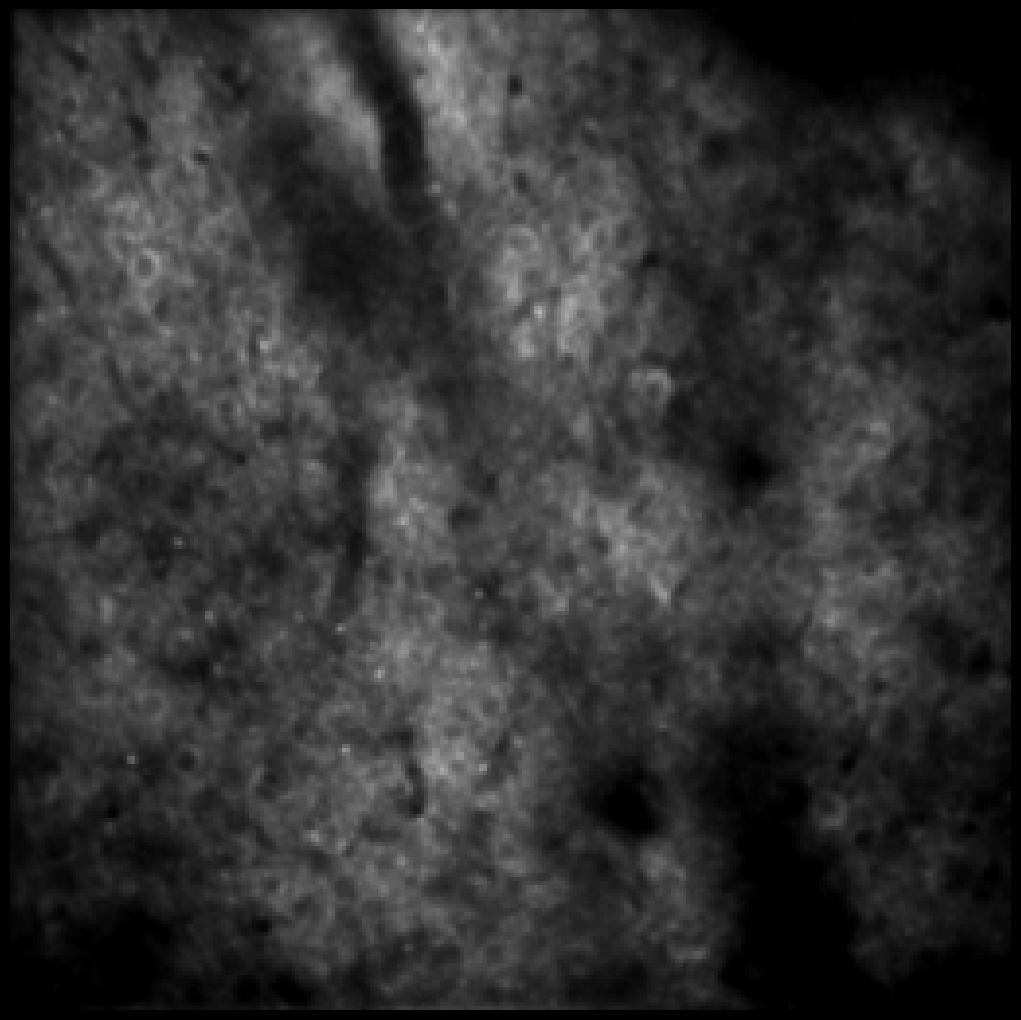

In [18]:
# just mean image
scalemin = 5
scalemax = 100

cmin = np.percentile(average_image,scalemin) 
cmax = np.percentile(average_image,scalemax) + offset


# plt.subplot(1, 4, 1)
plt.imshow(average_image, cmap='gray', vmin = cmin, vmax = cmax)
plt.show()


### make cam-synchronized movie

In [19]:
from pathlib import Path
import skvideo.io

# get the movie file name from the database
topfile = (model.VideoRecording.File & scan_key).fetch('file_path')[0]

#load to array
videodata = skvideo.io.vread(str(topfile))
# videodata = np.asarray([skvideo.io.vshape(frame)[0] for frame in videodata], dtype=np.uint8)

IndexError: index 0 is out of bounds for axis 0 with size 0

#### make DLC overlay video

In [20]:
model.VideoRecording & scan_key

session_id,recording_id,scanner


In [ ]:
# DEEPLABCUT OVERLAY - CURRENTLY ONLY WORKING IN MY ENVIRONMENT. NEED TO CHECK VERSIONS
dlc_scan_key = (model.PoseEstimation & f'recording_id = "{scan_key["scan_id"]}"').fetch('KEY')[0] 
key = (model.VideoRecording & dlc_scan_key).fetch1('KEY')
key.update({'model_name': 'Head_orientation-NK', 'task_mode': 'trigger'})


from deeplabcut.utils.make_labeled_video import create_labeled_video
import yaml
from element_interface.utils import find_full_path
from adamacs.paths import get_dlc_root_data_dir


destfolder = model.PoseEstimationTask.infer_output_dir(dlc_scan_key)

config_paths = sorted( # Of configs in the project path, defer to the datajoint-saved
    list(
        find_full_path(
            get_dlc_root_data_dir(), ((model.Model & key).fetch1("project_path"))
        ).glob("*.y*ml")
    )
)

create_labeled_video( # Pass strings to label the video
    config=str(config_paths[-1]),
    videos=str(topfile),
    destfolder=str(destfolder),
)

pattern = '*resnet*.mp4'
files = list(directory.glob(pattern))

# labeled_videofile = '/datajoint-data/data/tobiasr/JJ_WEZ-8873_2023-07-30_scan9FJBPNSP_sess9FJBPNSP/device_mini2p1_top_recording_scan9FJBPNSP_model_Head_orientation-NK/scan9FJBPNSP_top_video_2023-07-30T17_38_30DLC_resnet50_Head_orientationJul17shuffle1_90000_labeled.mp4'

labeled_videodata = skvideo.io.vread(str(files[0]))


In [21]:
from pathlib import Path
import skvideo.io
from deeplabcut.utils.make_labeled_video import create_labeled_video
import yaml
from element_interface.utils import find_full_path
from adamacs.paths import get_dlc_root_data_dir

dlc_scan_key = (model.PoseEstimation & f'recording_id = "{scan_key["scan_id"]}"').fetch('KEY')[0] 
destfolder = model.PoseEstimationTask.infer_output_dir(dlc_scan_key)

directory = Path(destfolder)
pattern = '*resnet*.mp4'
files = list(directory.glob(pattern))
labeled_videodata = skvideo.io.vread(str(files[0]))

2023-12-11 15:47:45.361093: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-11 15:47:45.476249: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/tobiasr/.local/lib/python3.8/site-packages/cv2/../../lib64:
2023-12-11 15:47:45.476270: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-12-11 15:47:45.503119: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already 

Loading DLC 2.3.5...
DLC loaded in light mode; you cannot use any GUI (labeling, relabeling and standalone GUI)


IndexError: list index out of range

#### load moving average registered Ca2+ imaging movie

In [22]:

scandir = (scan.ScanPath & scan_key).fetch('path')[0]

In [23]:
# get the registered moving average (blinking) movie data of the specified scanID

scandir = (scan.ScanPath & scan_key).fetch('path')[0]

directory = Path(scandir + "/suite2p/plane0/reg_tif")
pattern = '*.mp4'
files = list(directory.glob(pattern))
blinkvideodata = skvideo.io.vread(str(files[0]))
blinkvideodata = np.asarray([skvideo.io.vshape(frame)[0] for frame in blinkvideodata], dtype=np.uint8)



IndexError: list index out of range

In [ ]:
# display camaravideo with slider
sh.display_volume_z(videodata,1)

In [ ]:
# display 2pstackvideo with slider
sh.display_volume_z(blinkvideodata,1)

In [ ]:
# display 2pstackvideo with slider
sh.display_volume_z(labeled_videodata,1)

In [ ]:
#dimensionts of the original movie (frames, x,y,rgb)
print(videodata.shape)
print(blinkvideodata.shape)
print(labeled_videodata.shape)

#### Synchronization!

In [ ]:
 event.Event)

In [24]:
## Get the timestamp data and gate / offset cameraframes

# from the event table get the main recording gate start / end timestamps.
auxgatetimestamp_end = (event.Event()  &  "event_type='main_track_gate'" &  scan_key ).fetch('event_end_time')
auxgatetimestamp_start = (event.Event()  &  "event_type='main_track_gate'" &  scan_key ).fetch('event_start_time')

# Then return camera start timestamps within the recording gate only 
cameratimestamps = (event.Event()  &  "event_type='aux_cam'" & f"event_start_time>{auxgatetimestamp_start[0]}" & f"event_start_time<{auxgatetimestamp_end[0]}" & scan_key).fetch('event_start_time')

#  and 2p timestamps (which will always be in the recording gate).
twoptimestamps = (event.Event()  &  "event_type='mini2p_frames'" &  scan_key ).fetch('event_start_time')



IndexError: index 0 is out of bounds for axis 0 with size 0

In [ ]:
twoptimestamps =  twoptimestamps[:np.shape(blinkvideodata)[0]] # truncating 2p timestamps to number of 2p videoframes

#  Zero camera timestamps on first 2p timestamp. (not necessary)
# cameratimestamps = cameratimestamps - twoptimestamps[0]
# twoptimestamps = twoptimestamps - twoptimestamps[0]

In [ ]:
# align the two recordings by finding the indices of the closest camera timestamp that fits the 2p frame timestamps by sorted list insertion ("bisect"). Be aware: camera frames can be double.
aligned_cameraframes = get_closest_timestamps(twoptimestamps,cameratimestamps)

# this should have the same shape as the 2p frames:
print(np.shape(aligned_cameraframes))


In [ ]:

# now use this camara frame indices to reslice the video (which now is aligned to the 2p frames on a frame-by-frame level)
# resliced_cam_video = videodata[aligned_cameraframes]
resliced_cam_video = labeled_videodata[aligned_cameraframes]


In [ ]:
# display synchronized movie
sh.display_volume_z(resliced_cam_video,1)

In [ ]:
# rescale camera movie to fit size of 2p movie (can take a lot of time and memory)
rescaled_cam_movie = resize_movie(resliced_cam_video, np.shape(blinkvideodata)[1],np.shape(blinkvideodata)[2])

In [ ]:
np.shape(rescaled_cam_movie)

In [ ]:
# concatenate and display movies
concatmovie = np.concatenate((blinkvideodata,rescaled_cam_movie), axis = 2)
sh.display_volume_z(concatmovie,1)

In [ ]:
#save as new movie (without rescaling)


filename = str(directory) + '/aligned_stack_cam_movie.mp4'
fps = (scan.ScanInfo & scan_key).fetch('fps')
# p1 = 0
# p2 = 100
# trash = sh.make_stack_movie(concatmovie, filename, fps[0], p1, p2)

codecset = 'libx264'
import imageio
import imageio.plugins.ffmpeg as ffmpeg

# Create an imageio VideoWriter object to write the video
writer = imageio.get_writer(filename, fps=fps[0], codec=codecset, output_params=['-crf', '19'])

# # Calculate the 1st and 99th percentile
# p1, p99 = np.percentile(running_z_projection[:500,:,:], (p1set, p2set))

# # rescale to 8 bit
# rescaled_image_8bit = rescale_image_multithreaded(running_z_projection, p1, p99)

for page in concatmovie:
    writer.append_data(page)

# Close the video writer
writer.close()


In [ ]:
# speed up, add timestamps etc - all with fast ffmpeg operations

import os

spedby = 5
setpts_value = 1/spedby # change this to your desired value
newfps = fps[0]*spedby

input_filename = filename
# 2. Add timestamps

output_filename = str(directory) + '/' + scansi + '_top_video_concatenated' + 'withtimestamps.mp4'
command = f"""ffmpeg -y -i {input_filename} -vf "drawtext=fontfile=/Library/Fonts/Arial.ttf:timecode='00\\\\:00\\\\:00\\\\:00':rate={fps[0]}:text='':fontsize=15:fontcolor=white:x=260:y=10:box=1:boxcolor=0x00000000@1" -f mp4 {output_filename}"""

os.system(command)


input_filename = output_filename  # 'sped_up_video.mp4'
output_filename = str(directory) + '/' +  scansi + '_top_video_concatenated_spedup_' + str(spedby) + 'fold_withtimestamps.mp4'

command = f'ffmpeg -y -i {input_filename} -vf "setpts={setpts_value}*PTS" -r {newfps}  {output_filename}'



os.system(command)


## Plot activity

### Get the fluorescence traces of this recording

In [ ]:
# get mask positions of masks that are classified as cells and that are larger than a certain pixel size
mask_xpix, mask_ypix = (
    imaging.Segmentation.Mask * imaging.MaskClassification.MaskType
    & scan_key
    & "mask_npix > 1"
    & "curation_id = 1"
).fetch("mask_xpix", "mask_ypix")

Using this query, we've fetched the coordinates of segmented masks. We can overlay these
masks onto our average image.

In [ ]:
mask_image = np.zeros(np.shape(average_image), dtype=bool)
for xpix, ypix in zip(mask_xpix, mask_ypix):
    mask_image[ypix, xpix] = True

In [ ]:
# load image styles for display
mpl.rcParams.update(mpl.rcParamsDefault)
mpl.rcParams.update(img_params)

plt.imshow(average_image, cmap='gray', vmin = cmin, vmax = cmax)
plt.contour(mask_image, colors="red", linewidths=0.5)
plt.show()

In [ ]:
import matplotlib.colors as mcolors

# Normalize the average_image to [0, 1]
average_image = (average_image - average_image.min()) / (average_image.max() - average_image.min())

# Determine the number of masks
num_masks = len(mask_xpix)

# Generate random colormap using HSV
np.random.seed(42)  # For reproducibility, remove this line for truly random colors every time
hues = np.random.rand(num_masks)
colors = [mcolors.hsv_to_rgb([hue, 1, 1]) for hue in hues]

# # Create a color overlay using a perceptually uniform colormap
# colormap = plt.cm.viridis  # You can also use 'plasma', 'cividis', etc.
# colors = [colormap(i) for i in np.linspace(0, 1, num_masks)]


# Start with the grayscale image as the base
color_overlay = np.repeat(average_image[..., np.newaxis], 3, axis=2)

# Define an alpha factor for overall translucency (e.g., 0.5 for 50% transparency)
alpha_factor = 0.18

# Loop through masks, add color overlays
for (xpix, ypix), color in zip(zip(mask_xpix, mask_ypix), colors):
    for i in range(3):  # R, G, B channels
        color_overlay[ypix, xpix, i] = color_overlay[ypix, xpix, i] * (1 - alpha_factor) + color[i] * alpha_factor

# Display using Matplotlib
plt.imshow(color_overlay)
plt.show()


One more example using queries - plot fluorescence and deconvolved activity
traces:

Here we fetch the primary key attributes of the entry with `curation_id=0` for the
current session in the `imaging.Curation` table. 

Then, we fetch all cells that fit the
restriction criteria from `imaging.Segmentation.Mask` and
`imaging.MaskClassification.MaskType` as a `projection`. 

We then use this projection as
a restriction to fetch and plot fluorescence and deconvolved activity traces from the
`imaging.Fluorescence.Trace` and `imaging.Activity.Trace` tables, respectively.

In [ ]:
curation_key = (imaging.Curation & scan_key & "curation_id=1").fetch1("KEY")
query_cells = (
    imaging.Segmentation.Mask * imaging.MaskClassification.MaskType
    & curation_key
    & "mask_center_z=0"
    & "mask_npix > 1"
).proj()

# query_cells

In [ ]:
neuropilcorr = True

fluorescence_traces = (imaging.Fluorescence.Trace & query_cells).fetch(
    "fluorescence", order_by="mask"
)

neuropil_traces = (imaging.Fluorescence.Trace & query_cells).fetch(
    "neuropil_fluorescence", order_by="mask"
)

if neuropilcorr:
    print("DOING VANILLA NEUROPIL CORRECTION NOW!")
    fluorescence_traces = fluorescence_traces - 0.7 * neuropil_traces

activity_traces = (imaging.Activity.Trace & query_cells).fetch(
    "activity_trace", order_by="mask"
)

sampling_rate = (scan.ScanInfo & curation_key).fetch1("fps")

# timebase_2p = np.r_[: fluorescence_traces[0].size] * 1 / sampling_rate

timebase_2p = np.linspace(0, fluorescence_traces[0].size / sampling_rate, fluorescence_traces[0].shape[0])


In [ ]:
from rastermap import Rastermap
from scipy import stats 
from scipy.stats import zscore
from scipy.ndimage import gaussian_filter1d

# stack fluorescence for rastermap
fluos = np.vstack(fluorescence_traces)

nan_mask = np.isnan(fluos).any(axis=1)
S = fluos[~nan_mask]
S = zscore(S, axis=1)

rmmodel = Rastermap(n_clusters=None, # None turns off clustering and sorts single neurons 
                  n_PCs=80, # use fewer PCs than neurons
                  locality=0.15, # some locality in sorting (this is a value from 0-1)
                  time_lag_window=15, # use future timepoints to compute correlation
                  grid_upsample=0, # 0 turns off upsampling since we're using single neurons
                ).fit(S)


y = rmmodel.embedding # neurons x 1
isort = rmmodel.isort

# sort by embedding and smooth over neurons (uncomment)

# Sfilt = gaussian_filter1d(S[isort], np.minimum(1,np.maximum(1,int(S.shape[0]*0.001))),axis=0)
Sfilt = S[isort]

In [ ]:
# Plot sorted data
# load plot styles for display

mpl.rcParams.update(mpl.rcParamsDefault)
mpl.rcParams.update(plot_params)

plt.figure(figsize=(5,3))
plt.imshow(Sfilt, vmin = -0.1, vmax=1, extent= [timebase_2p[0], timebase_2p[-1], 0, Sfilt.shape[0]], aspect='auto', cmap='gray_r')
plt.xlabel('time [s]')
plt.ylabel('sorted neurons')
plt.show()

Binarized event visualization


In [ ]:
import seaborn as sns
figure = plt.figure(figsize=(5,6))
ax = figure.add_subplot(111)

thresh = 4
event_matrix = np.array([item > thresh for item in Sfilt], dtype=bool).astype(int)


offset_scaler = 1.5 # We want to plot every cell with a little offset to the last one
for no,trace in enumerate(event_matrix):
    if no == 80: break # not more than 80

    # get the neuropil corrected values for that trace:
    # trace = Sfilt
    ax.plot(timebase_2p,trace + (no*offset_scaler),lw=1,c='k',alpha=.8)
    # ax.plot(timebase_2p,trace + (no*offset_scaler),lw=1,c='r',alpha=.8)


ax.set_xlim(0,timebase_2p[-1])

ax.get_yaxis().set_ticks([])
ax.set_title('Sorted binarized z-scored traces - very preliminary')    

ax.set_ylabel('Cells')
ax.set_xlabel('Time [s]')
sns.despine(left=True)

plt.show()

#### Synchronization!

In [ ]:
## Get the timestamp data and gate / offset cameraframes

# from the event table get the main recording gate start / end timestamps.
auxgatetimestamp_end = (event.Event()  &  "event_type='main_track_gate'" &  scan_key ).fetch('event_end_time')
auxgatetimestamp_start = (event.Event()  &  "event_type='main_track_gate'" &  scan_key ).fetch('event_start_time')

# Then return camera start timestamps within the recording gate only 
cameratimestamps = (event.Event()  &  "event_type='aux_cam'" & f"event_start_time>{auxgatetimestamp_start[0]}" & f"event_start_time<{auxgatetimestamp_end[0]}" & scan_key).fetch('event_start_time')

#  and 2p timestamps (which will always be in the recording gate).
twoptimestamps = (event.Event()  &  "event_type='mini2p_frames'" &  scan_key ).fetch('event_start_time')

# align the two recordings by finding the indices of the closest camera timestamp that fits the 2p frame timestamps by sorted list insertion ("bisect"). Be aware: camera frames can be double.
aligned_cameraframes = get_closest_timestamps(twoptimestamps,cameratimestamps)

# this should have the same shape as the 2p frames:
print(np.shape(aligned_cameraframes))


In [ ]:
# the timestamps of the video synchronization from above are the one to use for synchronized plotting of positions etc: aligned_cameraframes
print(np.shape(cameratimestamps))
print(np.shape(aligned_cameraframes))
print(np.shape(twoptimestamps))

### now do some positional plotting!

In [ ]:
dlc_scan_key = (model.PoseEstimation & f'recording_id = "{scan_key["scan_id"]}"').fetch('KEY')[0] 
path = (model.VideoRecording.File & scan_key).fetch("file_path")
path

In [ ]:
#reduce dataframe to xy coordinates

df=model.PoseEstimation.get_trajectory(dlc_scan_key)
df_xy = df.iloc[:,df.columns.get_level_values(2).isin(["x","y"])]['Head_orientation-NK']
# df_xy.mean()
# df_xy
df_xy.plot().legend(loc='right')
plt.show()

In [ ]:
df_flat = df_xy.copy()
df_flat.columns = df_flat.columns.map('_'.join)

fig,ax=plt.subplots()
df_flat.plot(x='body_middle_x',y='body_middle_y',ax=ax)
df_flat.plot(x='head_middle_x',y='head_middle_y', ax=ax)
df_flat.plot(x='tail_x',y='tail_y', ax=ax)
ax.set_aspect('equal')
plt.title(scan_key)
plt.show()

In [ ]:
# plot events over position

position = df_flat[['body_middle_x', 'body_middle_y']].values
position = position[aligned_cameraframes].T/10 # synchronize to 2pframes and translate for opexebo - THIS IS A GUESSTIMATE!  pretending 1px = 1mm NEEDS CALIBRATION - tracking needs to be in xy real-world coordinates (in cm)


total_cells = np.shape(event_matrix)[0] # Change this to the desired number of cells

# Determine the grid dimensions (for a roughly square arrangement)
nrows = int(np.ceil(np.sqrt(total_cells)))
ncols = int(np.ceil(total_cells / nrows))

fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 12))
fig.subplots_adjust(hspace=0.2) # Add some space between the subplots

# If axs is not already a 2D array (e.g., if total_cells is a perfect square), make it one
if total_cells != nrows * ncols:
    axs = axs.reshape(-1)

# load image styles for display
mpl.rcParams.update(mpl.rcParamsDefault)
mpl.rcParams.update(map_params)

for cell in range(total_cells):
    ax = axs[cell]

    # Plotting the line plot first
    ax.plot(position[0], position[1], color='grey')

    # spike events at position
    spikes_at_pos = np.vstack((position[0, event_matrix[cell].astype("bool")], position[1, event_matrix[cell].astype("bool")]))
    
    # Then plotting the scatter plot so that it's on top of the line
    ax.scatter(spikes_at_pos[0], spikes_at_pos[1], color='red', zorder=2)

    ax.set_aspect('equal')
    ax.set_title(scan_key["scan_id"] + " - Cell " + str(cell+1))

# Remove any extra subplots
for cell in range(total_cells, nrows * ncols):
    fig.delaxes(axs[cell])

plt.show()

In [ ]:
# make masked spatial occupancy map - OPEXEBO

import opexebo

arena_size = 100 # in cm - NEEDS CALIBRATED TRACKING COORDS!
arena_shape = "circle"
bin_width =  4 # cm

masked_occupancy_map, coverage, bin_edges = opexebo.analysis.spatial_occupancy(timebase_2p, position, arena_size, arena_shape = arena_shape, bin_width = bin_width)

plt.figure(figsize=(5,3))
plt.imshow(masked_occupancy_map)
cbar = plt.colorbar()
cbar.set_label('time / bin [s]')
plt.title(f'spatial occupancy - {scan_key["scan_id"]}')
plt.show()

In [ ]:
# spike events at position
spikes_at_pos = np.vstack((position[0, event_matrix[cell].astype("bool")], position[1, event_matrix[cell].astype("bool")]))

# time at postiion
time_at_pos = (timebase_2p[event_matrix[cell].astype("bool")])

# spikes_tracking [t,x,y]
spikes_tracking = np.vstack((time_at_pos, spikes_at_pos))

# make ratemap
rate_map = opexebo.analysis.rate_map(masked_occupancy_map, spikes_tracking, arena_size, arena_shape = arena_shape, bin_width = bin_width)

In [ ]:
# plot rate maps - OPEXEBO

# Determine the grid dimensions (for a roughly square arrangement)
nrows = int(np.ceil(np.sqrt(total_cells)))
ncols = int(np.ceil(total_cells / nrows))

fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 12))
fig.subplots_adjust(hspace=0.2) # Add some space between the subplots

# If axs is not already a 2D array (e.g., if total_cells is a perfect square), make it one
if total_cells != nrows * ncols:
    axs = axs.reshape(-1)

# load image styles for display
mpl.rcParams.update(mpl.rcParamsDefault)
mpl.rcParams.update(map_params)

for cell in range(total_cells):
    ax = axs[cell]

    # spike events at position
    spikes_at_pos = np.vstack((position[0, event_matrix[cell].astype("bool")], position[1, event_matrix[cell].astype("bool")]))
    
    # time at postiion
    time_at_pos = (timebase_2p[event_matrix[cell].astype("bool")])
    
    # spikes_tracking [t,x,y]
    spikes_tracking = np.vstack((time_at_pos, spikes_at_pos))
    
    # make ratemap
    rate_map = opexebo.analysis.rate_map(masked_occupancy_map, spikes_tracking, arena_size, arena_shape = arena_shape, bin_width = bin_width)
    
    # Then plotting the scatter plot so that it's on top of the line
    im = ax.imshow(rate_map)

    ax.set_aspect('equal')
    ax.set_title(scan_key["scan_id"] + " - " + str(cell+1))
    # cbar = plt.colorbar(im, ax=ax) # Pass the image object and the ax to plt.colorbar
    # cbar.set_label('events / bin [s]')

# Remove any extra subplots
for cell in range(total_cells, nrows * ncols):
    fig.delaxes(axs[cell])

plt.show()

### speed tuning - freely moving

In [ ]:
# get running speed - OPEXEBO
new_speed = opexebo.analysis.calc_speed(timebase_2p, position[0], position[1], moving_average = 7)

In [ ]:

from matplotlib.ticker import MaxNLocator

mpl.rcParams.update(mpl.rcParamsDefault)
mpl.rcParams.update(plot_params)

# get some scaling values from pixel distribution
scalemin = 0
scalemax = 99.7

cmin = np.percentile(new_speed,scalemin)  
cmax = np.percentile(new_speed,scalemax)

kp_colors = np.array([[0.55,0.55,0.55]])


# timepoints to visualize
tstart = 0
tend =  timebase_2p[-1] - 150

xmin = int(np.floor(tstart * sampling_rate))
xmax = int(np.floor(tend * sampling_rate))

# make figure with grid for easy plotting
fig = plt.figure(figsize=(8,5), dpi=200)
grid = plt.GridSpec(9, 20, figure=fig, wspace = 0.05, hspace = 0.3)

# plot running speed
ax = plt.subplot(grid[:2, :-1])
ax.plot(new_speed,  color=kp_colors[0])
ax.set_xlim([0, xmax-xmin])
ax.set_ylim([cmin, cmax])

ax.axis("off")
ax.set_title("freely moving running speed", color=kp_colors[0])
# ax.set_xlabel("running speed")


# plot superneuron activity
ax = plt.subplot(grid[2:, :-1])
ax.imshow(Sfilt[:, xmin:xmax], cmap="gray_r", vmin=-0.1, vmax=0.8,  extent= [timebase_2p[xmin], timebase_2p[xmax], 0, Sfilt.shape[0]], aspect="auto")
ax.set_xlabel("time [s]")
ax.set_ylabel("sorted cells")

ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.yaxis.set_major_locator(MaxNLocator(integer=True))
plt.show()

# ax = plt.subplot(grid[1:, -1])
# ax.imshow(np.arange(0, len(sn))[:,np.newaxis], cmap="gist_ncar", aspect="auto")
# ax.axis("off")